## Multi-Mode Resource-Constrained Project Scheduling

This notebook demonstrates how to model and solve the classical Multi-Mode Resource-Constrained Project Scheduling Problem using Constraint Programming with IBM’s CP Optimizer via the [docplex.cp](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API, and subsequently solving the problem in [OptalCP](https://optalcp.com/) via the OptalCP [Python API](https://github.com/ScheduleOpt/optalcp-py). The MMRCPSP is a generalization of the Resource-Constrained Project Scheduling problem, see [rcpsp.ipynb](https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb).

### Problem Definition

In the MMRCPSP, we consider a finite set of tasks indexed by $i \in \{1,\dots,N\}$, where each task $i$ has a mode set $M[i]$ and exactly one mode $j \in M[i]$ must be chosen. The project uses two resource classes: renewable resources indexed by $k \in \{1, \dots, R\}$ with capacities $\mathrm{CR}_k>0$, and nonrenewable resources indexed by $k \in \{1,\dots,S\}$ with capacities $\mathrm{CS}_k>0$. For every task–mode pair $(i,j)$ with $j \in M[i]$, the duration is $PT_{ij}>0$, the renewable demand on resource $k$ is $\mathrm{QR}_{ijk}\ge 0$ (consumed only while the task in mode $j$ is executing), and the nonrenewable usage on resource $k$ is $\mathrm{QS}_{ijk}\ge 0$. A set of precedence relations $P \subseteq \{1,\dots,N\}^2$ specifies the required order of tasks. A feasible schedule assigns a mode to every task and start times such that: (i) all precedences in $P$ are respected; (ii) at every time point, the sum of renewable demands of all currently executing chosen modes does not exceed $\mathrm{CR}_k$ for each renewable $k$; and (iii) the total nonrenewable consumption $\sum_{i}\sum_{j \in M[i]} \delta_{ij}\,\mathrm{QS}_{ijk}$ does not exceed $\mathrm{CS}_k$ for each nonrenewable $k$, where $\delta_{ij}\in\{0,1\}$ indicates whether mode $j$ is chosen for task $i$. The objective is to minimize the makespan $C_{\max}$, i.e., the completion time of the last finishing task, over all feasible assignments of modes and start times.


### CP Formulation

$$
\begin{aligned}
\min \quad 
& \max_{i \in [1..N]} \mathrm{endOf}(x_i) 
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \mathrm{alternative}\!\left(x_i,\; [\,y_{ij}\,]_{j\in M[i]}\right), 
\qquad & \forall i\in[1..N] 
\quad & \text{(2)} \\[1mm]
& \sum_{i\in[1..N]}\sum_{j\in M[i]} 
  \mathrm{pulse}\!\left(y_{ij},\, \mathrm{QR}_{ijk}\right)
  \le \mathrm{CR}_k, 
\qquad & \forall k\in[1..R] 
\quad & \text{(3)} \\[1mm]
& \sum_{i\in[1..N]}\sum_{j\in M[i]} 
  \mathrm{presenceOf}(y_{ij})\cdot \mathrm{QS}_{ijk}
  \le \mathrm{CS}_k, 
\qquad & \forall k\in[1..S] 
\quad & \text{(4)} \\[1mm]
& \mathrm{endBeforeStart}(x_i, x_j), 
\qquad & \forall (i,j)\in P 
\quad & \text{(5)} \\[1mm]
& \text{interval } x_i, 
\qquad & \forall i\in[1..N] 
\quad & \text{(6a)} \\[1mm]
& \text{interval } y_{ij}\ \text{optional, size}=PT_{ij}, 
\qquad & \forall i\in[1..N],\ \forall j\in M[i] 
\quad & \text{(6b)}
\end{aligned}
$$


Objective:
- **(1)** The makespan $C_{\max}$ — the completion time of the last finishing task — is **minimized**.

Modeling constraints:
- **(2)** Ensures that exactly one mode $y_{ij}$ is selected for task $i$ and its timing matches $x_i$.
- **(3)** Enforces renewable resource limits so that, at any time.
- **(4)** Enforces nonrenewable resource limits at the project level.
- **(5)** Maintains all precedence relations $(i,j)\in P$.

Variables:
- **(6a)** $x_i$: a mandatory interval representing the execution of task $i$.  
- **(6b)** $y_{ij}$: optional intervals, each representing task $i$ performed in mode $j$ with fixed duration $PT_{ij}$.


#### Note on the [`alternative()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) and the [`presenceOf()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) functions

- **$\mathrm{alternative}(x_i,\,[y_{ij}])$** — links a mandatory interval $x_i$ with a set of optional intervals $y_{ij}$. Exactly one $y_{ij}$ must be present, and when it is, its start, end, and duration define those of $x_i$. Typically used to model exclusive mode or machine choices for a single task.

- **$\mathrm{presenceOf}(y_{ij})$** — returns $1$ if the optional interval $y_{ij}$ is present in the solution (that mode is chosen), and $0$ otherwise. It allows expressing logical or resource constraints depending on whether an operation or mode is active.


#### Symbols and Notation

| Symbol / Function | Meaning | DOcplex reference | OptalCP reference |
|---|---|---|---|
| $N$ | Number of tasks | — | — |
| $M[i]$ | Mode set of task $i$ | — | — |
| $R, S$ | Number of renewable / nonrenewable resources | — | — |
| $PT_{ij}$ | Duration of task $i$ in mode $j$ | — | — |
| $P$ | Precedence relations; $(i,j) \in P$ means $i$ must precede $j$ | — | — |
| $\mathrm{QR}_{ijk}$ | Renewable demand of task $i$ in mode $j$ on resource $k$ | — | — |
| $\mathrm{QS}_{ijk}$ | Nonrenewable use of task $i$ in mode $j$ on resource $k$ | — | — |
| $\mathrm{CR}_k, \mathrm{CS}_k$ | Capacities of renewable / nonrenewable resource $k$ | — | — |
| $x_i$ | Mandatory interval variable for task $i$ | [docplex.cp.modeler.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) | [interval_var](https://optalcp.com/docs/api/classes/IntervalVar) |
| $y_{ij}$ | Optional interval for mode $j$ of task $i$ | [docplex.cp.modeler.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) | [interval_var](https://optalcp.com/docs/api/classes/IntervalVar) |
| $\mathrm{alternative}(x_i,\,[y_{ij}])$ | Selects exactly one mode $y_{ij}$ and synchronizes it with $x_i$ | [docplex.cp.modeler.alternative](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) | [interval_var.alternative](https://optalcp.com/docs/api/classes/IntervalVar#alternative) |
| $\mathrm{pulse}(y_{ij},\, \mathrm{QR}_{ijk})$ | Time-varying usage of renewable resource $k$ while $y_{ij}$ executes | [docplex.cp.modeler.pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) | [interval_var.pulse](https://optalcp.com/docs/api/classes/IntervalVar#pulse) |
| $\mathrm{presenceOf}(y_{ij})$ | 1 if the optional interval is present, else 0 | [docplex.cp.modeler.presence_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) | [interval_var.is_present](https://optalcp.com/docs/api/classes/IntervalVar#ispresent) |
| $\mathrm{endBeforeStart}(x_i, x_j)$ | Enforce $x_j$ to start after $x_i$ ends | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) | [interval_var.end_before_start](https://optalcp.com/docs/api/classes/IntervalVar#endbeforestart) |
| $\max_i\, \mathrm{endOf}(x_i)$ | Makespan of the project | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) | [interval_var.end](https://optalcp.com/docs/api/classes/IntervalVar#end) |
| $\min C_{\max}$ | Objective: minimize makespan | [docplex.cp.modeler.minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) | [model.minimize](https://optalcp.com/docs/api/classes/Model#minimize) |


### Data Import & Parsing

In [1]:
from pathlib import Path

In [2]:
def next_ints(f):
    """Read next non-empty line of integers from file."""
    while not (line := list(map(int, f.readline().split()))):
        pass
    return line

In [3]:
def load_instance(filename):
    """Load RCPSP-MM (Multi-mode) instance from file.
    Returns: (N, R, S, CR, CS, M, P, PT, QR, QS) where:
        - N: Number of tasks
        - R: Number of renewable resources
        - S: Number of non-renewable resources
        - CR: Capacities of renewable resources [CR_1, ..., CR_R]
        - CS: Capacities of non-renewable resources [CS_1, ..., CS_S]
        - M: Mode set M[i] for each task i, dict {task_id: [1, 2, ..., m]}
        - P: Precedence relations; list of (i,j) pairs where i must precede j
        - PT: Duration PT_{ij}, dict {(task, mode): duration}
        - QR: Renewable demand QR_{ijk}, dict {(task, mode): [q_1, ..., q_R]}
        - QS: Non-renewable use QS_{ijk}, dict {(task, mode): [q_1, ..., q_S]}
    """
    with open(filename) as f:
        N, R, S = next_ints(f)
        CR, CS = next_ints(f), next_ints(f)
        tasks = [next_ints(f) for _ in range(N)]
        modes = [next_ints(f) for _ in range(sum(t[1] for t in tasks))]
    
    M = {t[0]: list(range(1, t[1] + 1)) for t in tasks}
    P = [(t[0], s) for t in tasks for s in t[3:3+t[2]]]
    PT = {(m[0], m[1]): m[2] for m in modes}
    QR = {(m[0], m[1]): m[3:3+R] for m in modes}
    QS = {(m[0], m[1]): m[3+R:3+R+S] for m in modes}
    
    return N, R, S, CR, CS, M, P, PT, QR, QS

In [6]:
N, R, S, CR, CS, M, P, PT, QR, QS = load_instance("../data/rcpspmm/rcpspmm_default.data")

### IBM CPO DOcplex Implementation

> This notebook is an adaptation of the *MMRCPSP* example from the [IBM Decision Optimization CPLEX Modeling for Python (DOcplex) Examples Repository](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master).  

#### Imports

In [7]:
from docplex.cp.model import *
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt

#### Create model and variables

In [8]:
# create a CP Optimizer model
mdl = CpoModel(name="mmrcpsp_cpo")

# (6a) x_i: mandatory intervals
x = { i: interval_var(name=f"x_{i}") for i in range(N) }  

# (6b) y_ij: optional intervals per mode with fixed size PT_ij
y = { (i,j): interval_var(name=f"y_{i}_{j}", optional=True, size=PT[(i,j)])
      for i in range(N) for j in M[i] }     


#### Add constraints and objective

In [9]:
# (1) objective: minimize makespan max_i endOf(x_i)
mdl.add(minimize(max(end_of(x[i]) for i in range(N))))

# (2) mode selection: alternative(x_i, {y_ij | j∈M[i]})
mdl.add(alternative(x[i], [y[(i, j)] for j in M[i]]) for i in range(N))

# (3) renewable capacity: sum pulse(y_ij, QR_ijk) ≤ CR_k
mdl.add([sum(pulse(y[(i, j)], QR[(i, j)][k])
        for (i, j) in PT if QR[(i, j)][k] > 0) <= CR[k] for k in range(R)])

# (4) nonrenewable capacity: sum presenceOf(y_ij)*QS_ijk ≤ CS_k
mdl.add([sum(presence_of(y[(i, j)]) * QS[(i, j)][k]
        for (i, j) in PT if QS[(i, j)][k] > 0) <= CS[k] for k in range(S)])

# (5) precedences: enforce endBeforeStart on arcs P
mdl.add([end_before_start(x[i], x[j]) for (i, j) in P])

#### Solve the model

In [10]:
print('Solving model...')
res = mdl.solve(TimeLimit=10, LogVerbosity='Quiet')
print('Solution:')
res.print_solution()

Solving model...
Solution:
-------------------------------------------------------------------------------
Model constraints: 94, variables: integer: 0, interval: 136, sequence: 0
Solve status: Optimal
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.3 sec
-------------------------------------------------------------------------------
Objective values: (40,), bounds: (39,), gaps: (0.025,)
Variables:
   x_0 = IntervalVarValue(start=0, end=0, size=0)
   x_1 = IntervalVarValue(start=0, end=1, size=1)
   x_2 = IntervalVarValue(start=2, end=3, size=1)
   x_3 = IntervalVarValue(start=1, end=2, size=1)
   x_4 = IntervalVarValue(start=4, end=7, size=3)
   x_5 = IntervalVarValue(start=1, end=8, size=7)
   x_6 = IntervalVarValue(start=4, end=8, size=4)
   x_7 = IntervalVarValue(start=4, end=10, size=6)
   x_8 = IntervalVarValue(start=3, end=4, size=1)
   x_9 = IntervalVarValue(start=2, end=6, size=4)
   x_10 = IntervalVarValue(start=8, end=13, size=5)
   x_11 = I

#### Visualisation

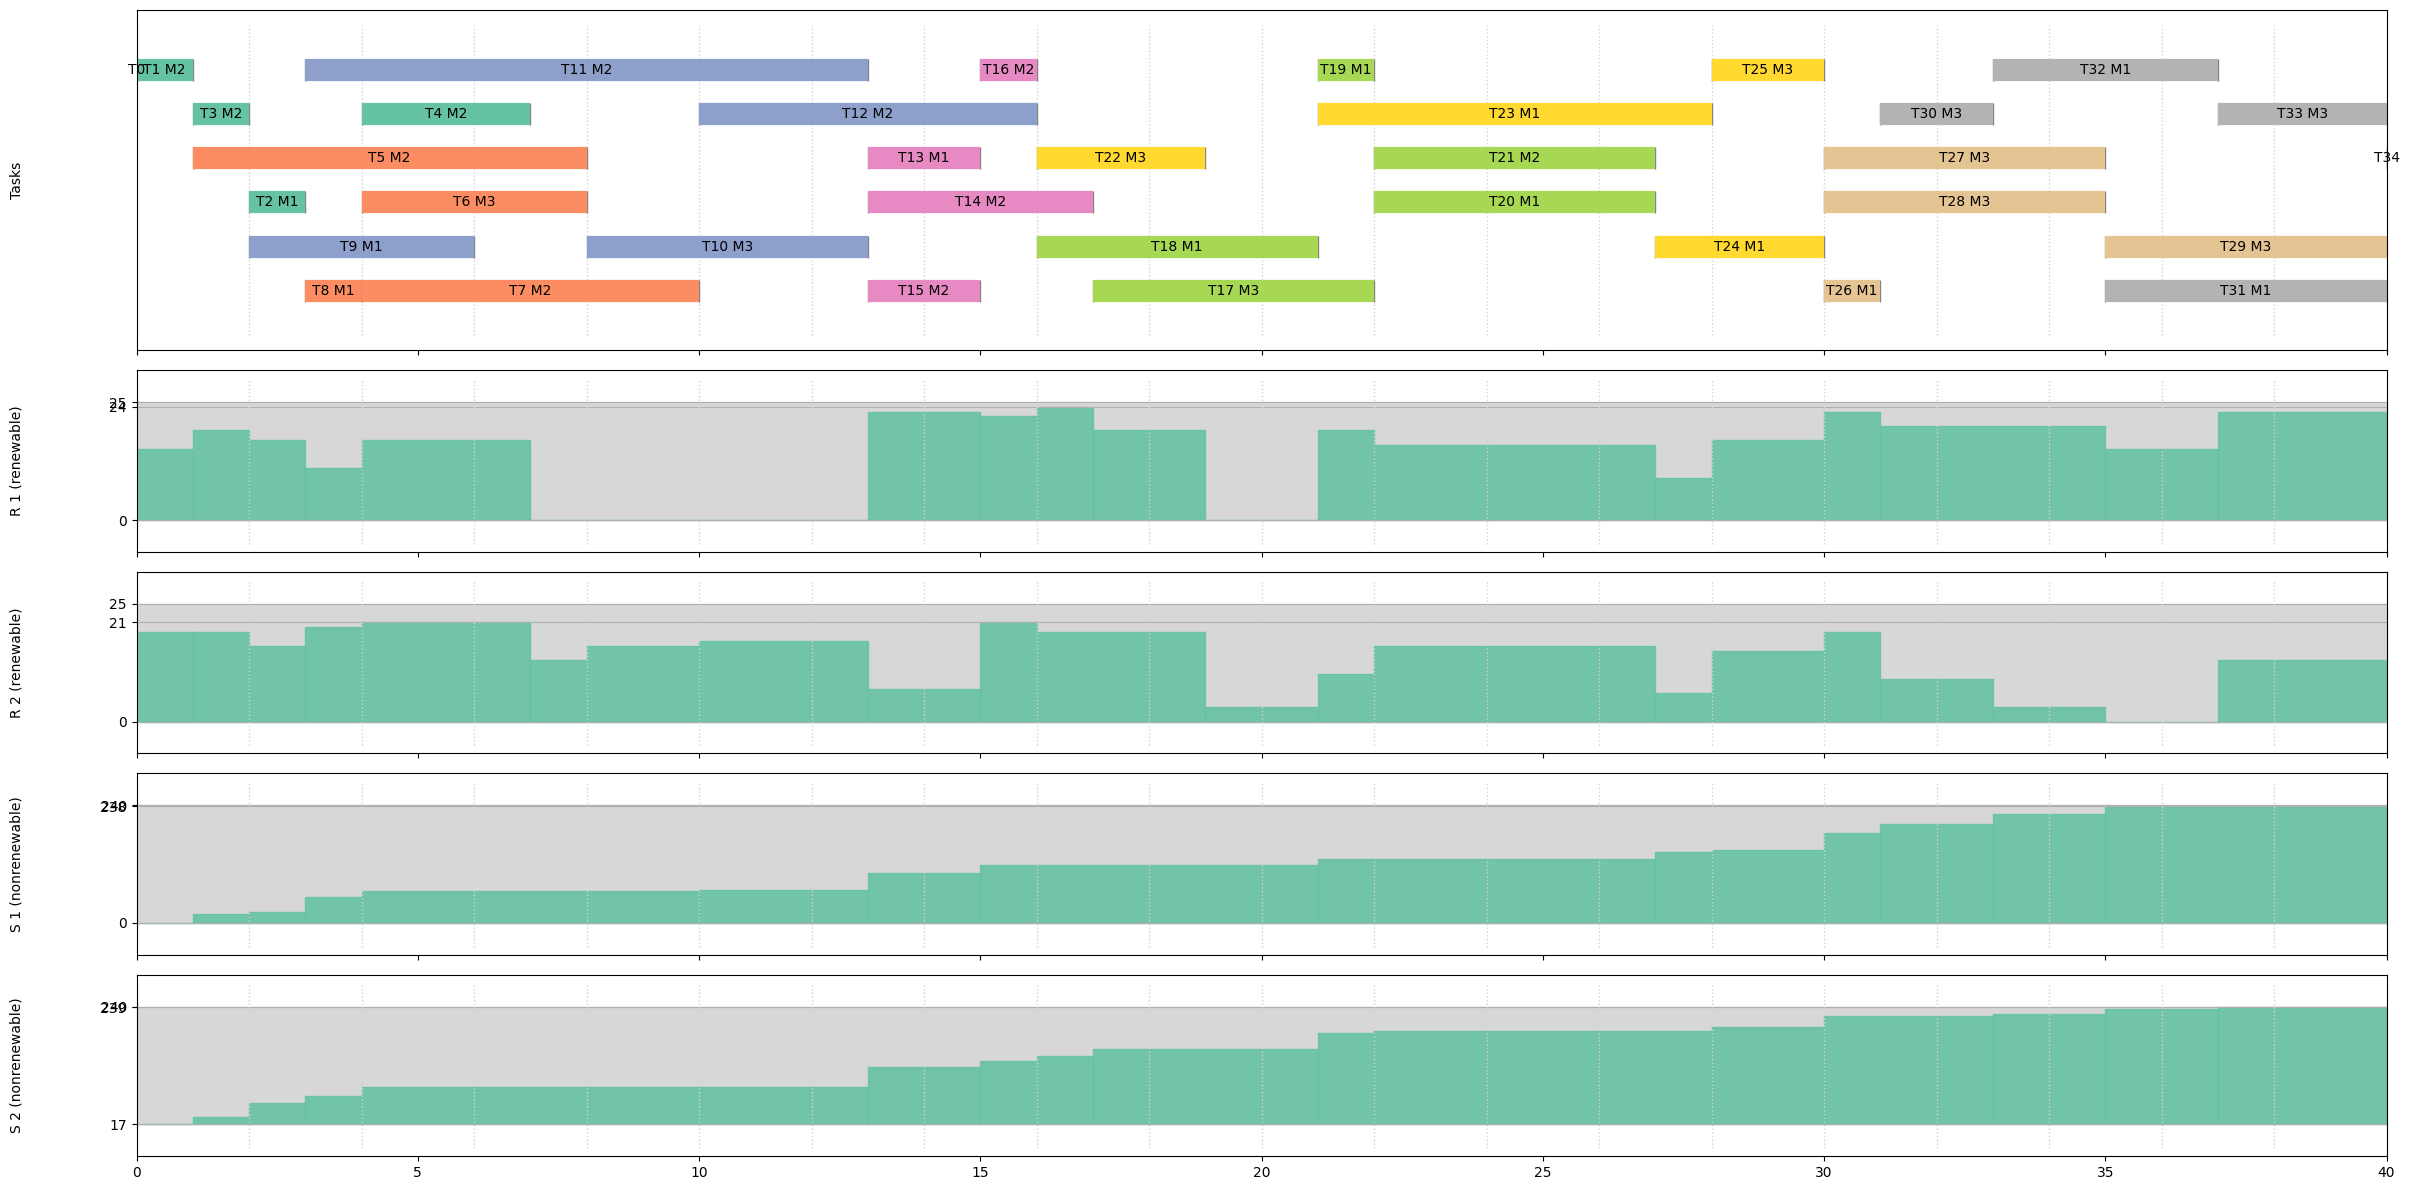

In [11]:
if res and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (24, 12)
    load_R = [CpoStepFunction() for k in range(R)]
    load_S = [CpoStepFunction() for k in range(S)]
    for (i, j), yij in y.items():
        itv = res.get_var_solution(yij)
        if itv.is_present():
            s, e = itv.get_start(), itv.get_end()
            for k in range(R):
                q = QR[(i, j)][k]
                if q > 0:
                    load_R[k].add_value(s, e, q)
            for k in range(S):
                q = QS[(i, j)][k]
                if q > 0:
                    load_S[k].add_value(s, INTERVAL_MAX, q)
    visu.panel('Tasks')
    for i in range(N):
        xi = res.get_var_solution(x[i])
        chosen = next((j for j in M[i] if res.get_var_solution(y[(i, j)]).is_present()), None)
        label = f"T{i} M{chosen}" if chosen is not None and i != 0 and i != N-1 else f"T{i}"
        visu.interval(xi, i, label)
    for k in range(R):
        visu.panel(f"R {k+1} (renewable)")
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, CR[k])], style='area', color='lightgrey')
        visu.function(segments=load_R[k], style='area', color=k)
    for k in range(S):
        visu.panel(f"S {k+1} (nonrenewable)")
        # Capacity as a flat band; cumulative consumption as a rising step function
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, CS[k])], style='area', color='lightgrey')
        visu.function(segments=load_S[k], style='area', color=k)
    visu.show()

### OptalCP Implementation

#### Imports

In [12]:
import optalcp as cp

#### Create model and variables

In [13]:
# create OptalCP model
mdl = cp.Model(name="mmrcpsp_optal")

# (6a) define mandatory interval variables for each task x_i
x = [mdl.interval_var(name=f"T{i}") for i in range(N)]

# (6b) define optional interval variables for each mode y_ij with fixed duration PT_ij
y = {
    (i, j): mdl.interval_var(length=PT[(i, j)], optional=True, name=f"T{i}_M{j}")
    for i in range(N)
    for j in M[i]
}

#### Add constraints and define objective

In [14]:
# (1) objective: minimize makespan = max_i endOf(x_i)
mdl.minimize(mdl.max([x[i].end() for i in range(N)]))

# (2) alternative constraint: exactly one mode per task
for i in range(N):
    x[i].alternative([y[(i, j)] for j in M[i]])

# (3) renewable resource capacities
for k in range(R):
    if pulses := [y[(i, j)].pulse(height=QR[(i, j)][k]) for i in range(N) for j in M[i] if QR[(i, j)][k] > 0]:
        mdl.constraint(mdl.cumul_sum(pulses) <= CR[k])

# (4) nonrenewable resource budgets
for k in range(S):
    if usage := [y[(i, j)].is_present() * QS[(i, j)][k] for i in range(N) for j in M[i] if QS[(i, j)][k] > 0]:
        mdl.constraint(mdl.sum(usage) <= CS[k])

# (5) precedence constraints
for i, j in P:
    x[i].end_before_start(x[j])

#### Solve the model

In [15]:
print('Solving model...')
result = cp.solve(mdl, cp.Parameters(timeLimit=10))
print(result)

Solving model...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: mmrcpsp_optal
   0 integer variables, 136 interval variables, 94 constraints, 67kB
   00:00 Presolving..
Presolved:
   0 integer variables, 134 interval variables, 90 constraints, 59.2kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 38 Worker 1
   00:00 Solution 55 Worker 1: LNS
   00:00 Solution 40 Worker 1: LNS
   00:00 Solution 39 Worker 1: LNS
   00:00 Lower bound 39 Worker 1: Optimality proof
   00:00 Worker 1: The current best solution is opti

### Additional Resources

- **RCPSP**
    - https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb